In [1]:
import os
import pandas as pd
import numpy as np

import sys
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials

from dotenv import load_dotenv

load_dotenv()

True

In [2]:
client_credentials_manager = SpotifyClientCredentials()
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [24]:
os.getenv("SPOTIPY_CLIENT_ID")

'05f894ed0a46421ba1e24644733beeac'

Blink-182 song

In [3]:
# Songs
carousel = "3gVXAW2pduBl7tzjAGUVRb"
carousel_aa = sp.audio_analysis(carousel)

In [ ]:
carousel_aa.keys()

dict_keys(['meta', 'track', 'bars', 'beats', 'sections', 'segments', 'tatums'])

In [ ]:
len(carousel_aa["segments"])

775

divido a movimentação de um ponto em 12 direções

In [4]:
sp.album_tracks("0GqpoHJREPp0iuXK3HzrHk")["items"][0]['id']

'2e61kmae4HhbuS9hYONQ0A'

In [5]:
len(sp.album_tracks("0GqpoHJREPp0iuXK3HzrHk")["items"])

8

In [6]:
ids_houses_of_holy = [sp.album_tracks("0GqpoHJREPp0iuXK3HzrHk")["items"][i]['id'] for i in range(len(sp.album_tracks("0GqpoHJREPp0iuXK3HzrHk")["items"]))]

In [7]:
ids_houses_of_holy

['2e61kmae4HhbuS9hYONQ0A',
 '3JLrri1xSCui3bzITDJbkk',
 '2eDdFHgqNJltzlvlZFVDWd',
 '7IgBLFklu75pp8Y1vphChS',
 '43doj2cumGe9W3p5ucxaoH',
 '5uUhS7XDkyycNa5FaNfPGT',
 '0GRBFjza23Im7Xb16c9AaK',
 '0AqjkVFqa1ujle4Lb1k9wR']

In [8]:
-carousel_aa["segments"][0]["loudness_max"]

60.0

In [26]:
def getTrackIDs(user, playlist_id):
    ids = []
    playlist = sp.user_playlist(user, playlist_id)
    for item in playlist['tracks']['items']:
        track = item['track']
        ids.append(track['id'])
    return ids

def get_song_id_metrics(song_id):
    song_audio = sp.audio_analysis(song_id)
    coords = []
    # print(len(song_audio["segments"]))
    for i in range(len(song_audio["segments"])-1):
        data = process_pitch(song_audio["segments"][i]['pitches'])
        data.extend([-song_audio["segments"][i]["loudness_max"]])
        coords.append(data)
    return coords

def process_pitch(pitch_list):
    min_max_list = normalize(pitch_list)
    coordinates = get_coordinates(min_max_list)
    coordinates = list(np.sum(coordinates, axis=0))
    return coordinates

def normalize(input_list):
    min_val = min(input_list)
    max_val = max(input_list)
    if max_val == min_val:
        return [0 for x in input_list]
    # normalized_list = [(x - min_val) / (max_val - min_val) for x in input_list]
    normalized_list = [
        (2 * (x - min_val) / (max_val - min_val)) - 1 for x in input_list
    ]
    return normalized_list

def get_coordinates(normalized_input):
    i = 0
    coordinates = []
    for i in range(len(normalized_input) - 1):
        # print(normalized_input[i])
        cos = round(np.cos(i * 2 * np.pi/12), 5) * normalized_input[0]
        sin = round(np.sin(i * 2 * np.pi/12), 5) * normalized_input[1]
        # print((cos, sin))
        coordinates.append((cos, sin))
    return coordinates

In [27]:
database = {}
for i,song_id in enumerate(ids_houses_of_holy):
    database[f"{i}"] = {
        "metrics": get_song_id_metrics(song_id),
        "name": sp.track(song_id)['name'].lower()
        }

In [28]:
sp.track(song_id)['name'].lower()

'the ocean - remaster'

In [29]:
import json

with open("houses_of_the_holy.json", "w") as fp:
    json.dump(database , fp, indent = 4)

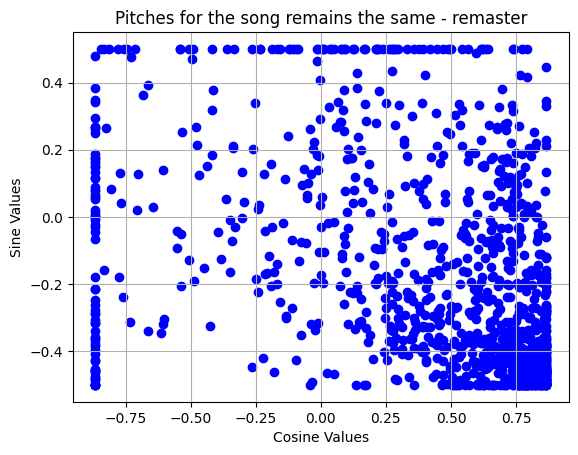

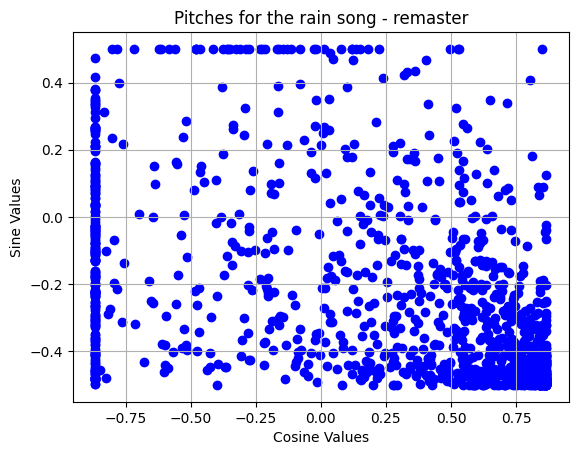

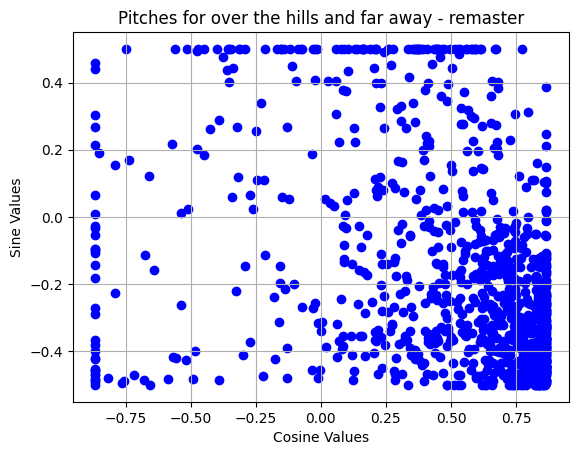

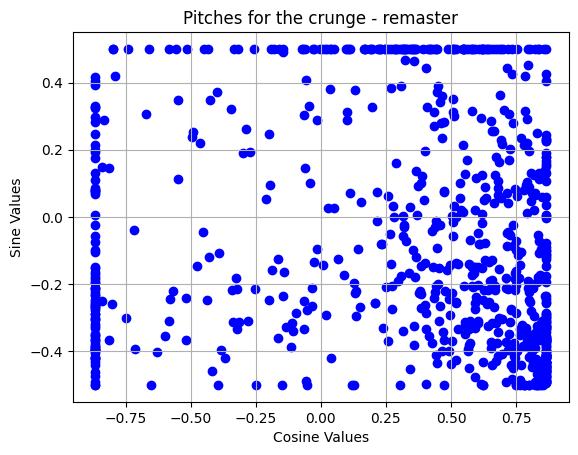

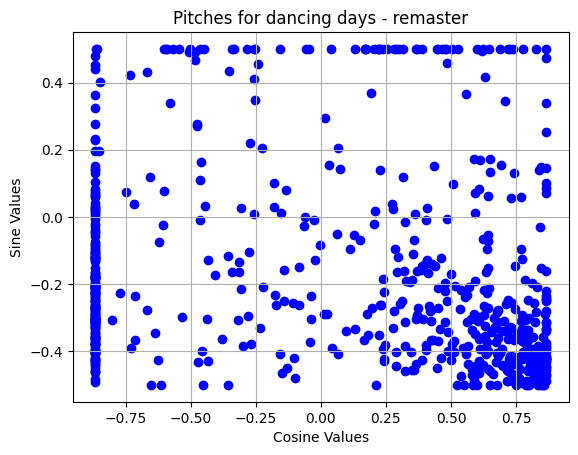

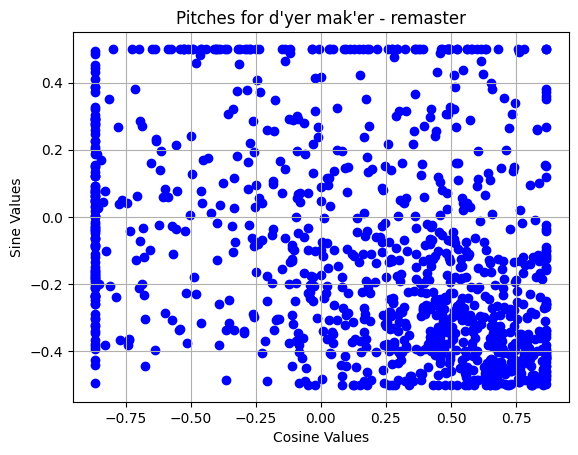

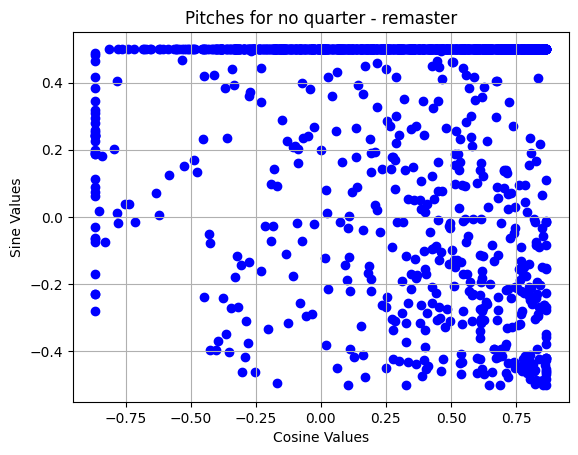

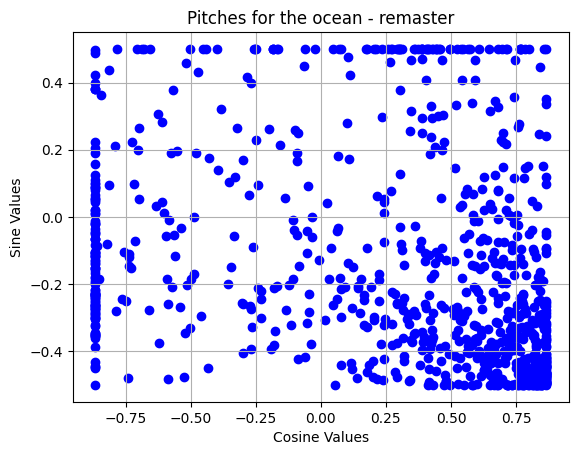

In [31]:
import matplotlib.pyplot as plt

for song_id, song_data in database.items():
    metrics = np.array(song_data["metrics"])
    plt.figure()
    plt.scatter(metrics[:, 0], metrics[:, 1], c='b', marker='o')
    plt.title(f'Pitches for {song_data["name"]}')
    plt.xlabel('Cosine Values')
    plt.ylabel('Sine Values')
    plt.grid(True)
    plt.show()